In [2]:
!pip install -q bitsandbytes accelerate nltk lightning peft datasets Pillow roboflow deepspeed accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 19.9 MB/s eta 0:00:00


In [3]:
from transformers import (BitsAndBytesConfig,
                          LlavaNextForConditionalGeneration,
                          AutoProcessor,
                          AutoTokenizer,
                          AutoModelForCausalLM)
import bitsandbytes as bnb
import torch

###deepseed

In [1]:
import torch
import deepspeed
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "AIDC-AI/Ovis2.5-2B"

# Thinking mode
enable_thinking = True
enable_thinking_budget = True
max_new_tokens = 3072
thinking_budget = 2048

# ---- Load model (fp16, trust remote) ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map=None,     # Let DeepSpeed manage devices
)

# ---- Initialize DeepSpeed inference engine (new syntax) ----
ds_engine = deepspeed.init_inference(
    model=model,
    tensor_parallel={"tp_size": 1},   # replaces mp_size
    dtype=torch.float16,
    replace_with_kernel_inject=True   # keep this, no replace_method needed
)
model = ds_engine.module  # Use this wrapped model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
# ---- Prepare input ----
image = Image.open(
    requests.get(
        "https://cdn-uploads.huggingface.co/production/uploads/658a8a837959448ef5500ce5/TIlymOb86R6_Mez3bpmcB.png",
        stream=True
    ).raw
)

image = Image.open("/content/OCR-L-AIRPORT-0911-8.jpg")

instruct = "give fire bbox in this formart bbox: [x_min, y_min, x_max, y_max]"



messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": instruct},
    ],
}]

input_ids, pixel_values, grid_thws = model.preprocess_inputs(
    messages=messages,
    add_generation_prompt=True,
    enable_thinking=enable_thinking
)

input_ids = input_ids.cuda()
pixel_values = pixel_values.cuda() if pixel_values is not None else None
grid_thws = grid_thws.cuda() if grid_thws is not None else None

# ---- Generate ----
with torch.inference_mode():
    outputs = model.generate(
        inputs=input_ids,
        pixel_values=pixel_values,
        grid_thws=grid_thws,
        enable_thinking=enable_thinking,
        enable_thinking_budget=enable_thinking_budget,
        max_new_tokens=max_new_tokens,
        thinking_budget=thinking_budget,
    )

# ---- Decode ----
response = model.text_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


<think>
用户现在需要确定火焰的bbox。看图片里火焰的范围，从左到右，火焰的高度和宽度。首先看火焰的左边界和右边界，还有上下。火焰在画面中占据中间到右侧，所以x_min大概0.3左右？不对，看图片中火焰的范围，应该是从左到右，火焰的范围是x从大约0.3到0.9左右？不对，再仔细看。图片中火焰是主要的橙色火焰，覆盖的区域。所以bbox应该是[0.3, 0.2, 0.9, 0.7]？不对，再看。火焰的高度是从地面到天空，所以y_min是0（地面），y_max是接近1（天空）。所以火焰的bbox是x从大约0.3到0.9，y从0到1左右。所以最终确定bbox为[0.3, 0.2, 0.9, 0.7]？不对，再检查。看图片中火焰的范围，左边火焰和右边火焰，中间的火焰。所以正确的bbox应该是[0.3, 0.2, 0.9, 0.7]？或者更准确的话，看火焰的左右边界。左边火焰的x大约是0.3，右边大约是0.9，上下是y从0到1。所以最终bbox是[0.3, 0.2, 0.9, 0.7]？</think>

[0.3, 0.2, 0.9, 0.7]


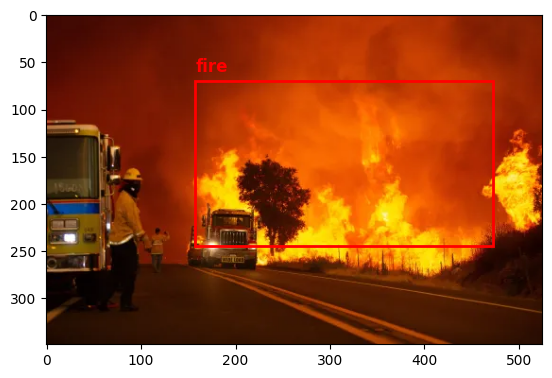

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import re
from PIL import Image

# Assuming the last output of the previous cell is the bounding box string
output_bbox_string = response # Replace 'response' with the actual variable name holding the output

# Extract the bounding box coordinates from the output
bbox_match = re.search(r'\[\d+\.\d+, \d+\.\d+, \d+\.\d+, \d+\.\d+\]', output_bbox_string)

if bbox_match:
    bbox_string = bbox_match.group(0)
    try:
        bbox = json.loads(bbox_string)
        # Format the bbox into the desired dictionary structure
        detections = [{"label": "fire", "confidence": 1.0, "bbox": bbox}] # Assuming confidence 1.0 for simplicity
    except json.JSONDecodeError:
        print("Error: Could not parse bounding box coordinates.")
        detections = []
else:
    print("Error: Could not find bounding box coordinates in the model response.")
    detections = []


# Load the image
image_path = "/content/OCR-L-AIRPORT-0911-8.jpg" # Corrected image path
try:
    image = Image.open(image_path)
    img_width, img_height = image.size
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    image = None
    img_width, img_height = 1, 1 # Prevent division by zero


if image:
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Draw bounding boxes
    for detection in detections:
        label = detection['label']
        # confidence = detection['confidence'] # Confidence is not available in the model output
        bbox = detection['bbox']

        # Scale normalized bounding box coordinates to image dimensions
        x_min, y_min, x_max, y_max = bbox
        x_min_abs = x_min * img_width
        y_min_abs = y_min * img_height
        x_max_abs = x_max * img_width
        y_max_abs = y_max * img_height


        # Create a Rectangle patch
        rect = patches.Rectangle((x_min_abs, y_min_abs), x_max_abs - x_min_abs, y_max_abs - y_min_abs, linewidth=2, edgecolor='r' if label == 'fire' else 'b', facecolor='none')

        # Add the patch to the axes
        ax.add_patch(rect)

        # Add label
        plt.text(x_min_abs, y_min_abs - 10, f'{label}', color='r' if label == 'fire' else 'b', fontsize=12, weight='bold')

    plt.show()

##4 bit

In [ ]:
bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )

In [1]:
%%writefile ds_zero3_offload.json
{
  "fp16": {
    "enabled": true
  },
  "zero_optimization": {
    "stage": 3,
    "offload_optimizer": { "device": "cpu", "pin_memory": true },
    "offload_param": { "device": "cpu", "pin_memory": true }
  },
  "train_batch_size": 1
}


Writing ds_zero3_offload.json


In [ ]:
import torch
import requests
from PIL import Image

MODEL_ID = "AIDC-AI/Ovis2.5-2B"

# Thinking mode & budget
enable_thinking = True
enable_thinking_budget = True  # Only effective if enable_thinking is True.

# Total tokens for thinking + answer. Ensure: max_new_tokens > thinking_budget + 25
max_new_tokens = 3072
thinking_budget = 2048



model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": Image.open(requests.get("https://cdn-uploads.huggingface.co/production/uploads/658a8a837959448ef5500ce5/TIlymOb86R6_Mez3bpmcB.png", stream=True).raw)},
        {"type": "text", "text": "Calculate the sum of the numbers in the middle box in figure (c)."},
    ],
}]

input_ids, pixel_values, grid_thws = model.preprocess_inputs(
    messages=messages,
    add_generation_prompt=True,
    enable_thinking=enable_thinking
)
input_ids = input_ids.cuda()
pixel_values = pixel_values.cuda() if pixel_values is not None else None
grid_thws = grid_thws.cuda() if grid_thws is not None else None


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

outputs = model.generate(
    inputs=input_ids,
    pixel_values=pixel_values,
    grid_thws=grid_thws,
    max_new_tokens=max_new_tokens,
)

response = model.text_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)


OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 35389 has 14.72 GiB memory in use. Of the allocated memory 13.76 GiB is allocated by PyTorch, and 852.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)